# Monte Carlo Simulation of a locked token (spot + perps)

## Simulation function

This is the main function that governs the MC strategy. It includes Binance's risk tiers (need to be inputted manually if we test different shitcoin in the TEST RUN section for now in the manual_eos_tiers - yes, I am lazy to rename). The idea is to simulate prices weekly (do note that the main price simulation setting happens in the MC section, here we just modify our outlook on the price. The degrees of freedom etc are just a fallback in case there are no inputs in the MC function later on).

In [52]:
import numpy as np
import pandas as pd
from scipy.stats import t as student_t
import requests  

try:
    import numpy_financial as npf
except ImportError:
    npf = None

def get_required_margin(notional, maint_data):
    """
    Given a notional and a list of maintenance margin tiers (maint_data),
    compute the required margin using the tier formula:
    
        tier_margin = max(notional * maintMarginRate - maintAmount, 0)
    
    Then, compare this with the default margin (1/3 of the notional)
    and return the higher value.
    
    The function determines the appropriate tier by checking where
    notional falls within [notionalFloor, notionalCap). If notional exceeds
    all tiers, the last tier is used.
    """
    for tier in maint_data:
        if tier["notionalFloor"] <= notional < tier["notionalCap"]:
            tier_margin = max(notional * tier["maintMarginRate"] - tier["maintAmount"], 0.0)
            default_margin = notional / 3.0
            return max(tier_margin, default_margin)
    # If notional exceeds all tiers, use the last tier.
    tier = maint_data[-1]
    tier_margin = max(notional * tier["maintMarginRate"] - tier["maintAmount"], 0.0)
    default_margin = notional / 3.0
    return max(tier_margin, default_margin)

def simulate_strategy_weekly(
    P0,
    investment_amount=None,
    num_tokens_granted=None,
    discount=0.0,
    hedge_ratio=1.0,
    T=156,
    annual_funding_rate=0.0,
    cliff_weeks=0,
    price_floor=None,
    seed=None,
    external_shocks=None,
    maint_margin_data=None,
    staking_apy=0.0,
    sell_frequency="weekly"
):
    if seed is not None:
        np.random.seed(seed)

    # --- Handle token logic ---
    if (investment_amount is None and num_tokens_granted is None) or (investment_amount is not None and num_tokens_granted is not None):
        raise ValueError("Please provide either investment_amount or num_tokens_granted, but not both.")

    if num_tokens_granted is not None:
        Q = num_tokens_granted
        token_cost = Q * P0 * (1 - discount)
    else:
        Q = investment_amount / (P0 * (1 - discount))
        token_cost = investment_amount  # for cash flow purposes

    # --- Price simulation ---
    price_outlook = "bearish"
    mu = np.log(1 + {"bearish": -0.4, "neutral": 0.0, "bullish": 0.1}.get(price_outlook, 0.0))
    dt = 1 / 52.0
    total_weeks = T
    prices = [P0]
    df_t = 5.0
    skew_strength = 0.5
    annual_vol = 0.4

    if external_shocks is not None:
        shocks = external_shocks
    else:
        shocks = student_t.rvs(df_t, size=total_weeks)
        shocks /= np.sqrt(df_t / (df_t - 2))
        shocks = np.where(shocks >= 0, shocks * (1 + skew_strength), shocks * (1 - skew_strength))

    for Z in shocks:
        last_price = prices[-1]
        Pt = last_price * np.exp((mu - 0.5 * annual_vol**2) * dt + annual_vol * np.sqrt(dt) * Z)
        prices.append(max(Pt, price_floor) if price_floor is not None else Pt)

    # --- Initial setup ---
    details = []
    collateral_series = []

    hedged_tokens = hedge_ratio * Q

    initial_required = get_required_margin(hedged_tokens * P0, maint_margin_data) if maint_margin_data else (1/3) * (hedged_tokens * P0)
    initial_collateral = initial_required
    cf0 = -token_cost - initial_collateral

    details.append({
        "time": 0.0, "week": 0, "price": P0,
        "remaining_long": Q, "remaining_short": hedged_tokens,
        "collateral": initial_collateral, "collateral_flow": -initial_collateral,
        "funding_cash_flow": 0.0, "hedged_sale_flow": 0.0, "hedged_cover_flow": 0.0,
        "unhedged_sale_flow": 0.0, "vesting_total_flow": 0.0,
        "staking_tokens_tokens": 0.0,
        "total_cf": cf0, "note": "Initial Setup"
    })

    remaining_long = Q
    remaining_short = hedged_tokens
    collateral = initial_collateral
    total_funding_cost = 0.0

    vest_weeks = max(total_weeks - cliff_weeks, 1)
    vest_per_week = Q / vest_weeks
    accumulated_vested = 0.0

    for t in range(1, total_weeks + 1):
        time_year = t / 52.0
        price_prev = prices[t - 1]
        current_price = prices[t]

        notional = remaining_short * price_prev
        new_collateral_required = get_required_margin(notional, maint_margin_data) if maint_margin_data else notional / 3.0

        collateral_change = new_collateral_required - collateral
        collateral_flow = -collateral_change
        collateral = new_collateral_required
        collateral_series.append(collateral)

        funding_cost = (annual_funding_rate / 52.0) * notional
        total_funding_cost += funding_cost

        staking_reward = (staking_apy / 52.0) * remaining_long 
        remaining_long += staking_reward

        if t > cliff_weeks:
            vested = vest_per_week
        else:
            vested = 0.0

        accumulated_vested += vested
        sell_this_week = (
            vested > 0 if sell_frequency == "weekly"
            else (t % 4 == 0 or t == total_weeks)
        )

        if sell_this_week:
            tokens_hedged_vesting = min(accumulated_vested, remaining_short)
            hedged_sale_flow = tokens_hedged_vesting * current_price
            hedged_cover_flow = tokens_hedged_vesting * (P0 - current_price)
            net_hedged = hedged_sale_flow + hedged_cover_flow

            tokens_unhedged = accumulated_vested - tokens_hedged_vesting
            unhedged_sale_flow = tokens_unhedged * current_price
            vesting_total_flow = net_hedged + unhedged_sale_flow

            remaining_short -= tokens_hedged_vesting
            remaining_long -= accumulated_vested
            accumulated_vested = 0.0
        else:
            hedged_sale_flow = hedged_cover_flow = unhedged_sale_flow = vesting_total_flow = 0.0

        total_cf_week = collateral_flow + funding_cost + vesting_total_flow

        details.append({
            "time": time_year, "week": t, "price": current_price,
            "remaining_long": remaining_long, "remaining_short": remaining_short,
            "collateral": collateral, "collateral_flow": collateral_flow,
            "funding_cash_flow": funding_cost,
            "hedged_sale_flow": hedged_sale_flow,
            "hedged_cover_flow": hedged_cover_flow,
            "unhedged_sale_flow": unhedged_sale_flow,
            "vesting_total_flow": vesting_total_flow,
            "staking_tokens_tokens": staking_reward,
            "total_cf": total_cf_week,
            "note": f"Week {t} - vested: {vested:.2f}, accumulated: {accumulated_vested:.2f}"
        })

    # --- Final settlement ---
    final_time = total_weeks / 52.0
    final_price = prices[-1]
    final_sale = remaining_long * final_price
    final_short_settlement = remaining_short * (P0 - final_price) if remaining_short > 0 else 0.0
    collateral_release = collateral
    final_total_cf = final_sale + final_short_settlement + collateral_release

    details.append({
        "time": final_time, "week": total_weeks, "price": final_price,
        "remaining_long": 0.0, "remaining_short": 0.0, "collateral": 0.0,
        "collateral_flow": collateral_release,
        "funding_cash_flow": 0.0,
        "hedged_sale_flow": 0.0,
        "hedged_cover_flow": final_short_settlement,
        "unhedged_sale_flow": final_sale,
        "vesting_total_flow": final_sale + final_short_settlement,
        "staking_tokens_tokens": 0.0,
        "total_cf": final_total_cf,
        "note": "Final Settlement"
    })

    # --- IRR and return ---
    cash_flows = [(row["time"], row["total_cf"]) for row in details]
    values_arr = np.array([cf for t, cf in cash_flows])
    irr = npf.irr(values_arr) if npf else None
    weekly_irr = irr
    annual_irr = (1 + weekly_irr)**52 - 1 if weekly_irr is not None else None
    total_pnl = np.sum(values_arr)
    df_details = pd.DataFrame(details)

    return {
        "prices": prices,
        "collateral_series": collateral_series,
        "cash_flows": cash_flows,
        "IRR": irr,
        "Total_PnL": total_pnl,
        "Total_Funding_Cost": total_funding_cost,
        "simulation_details": df_details,
        "Annualized IRR": annual_irr
    }



###############################################################################
# 4) TEST RUN ((https://www.binance.com/en/futures/trading-rules/perpetual/leverage-margin)
###############################################################################
if __name__ == "__main__":
    # Manually defined maintenance margin tiers based on your table 
    manual_eosusdt_tiers = [
    {"notionalFloor": 0,             "notionalCap": 5_000,         "maintMarginRate": 0.0100, "maintAmount": 0},
    {"notionalFloor": 5_000,         "notionalCap": 10_000,        "maintMarginRate": 0.0150, "maintAmount": 25},
    {"notionalFloor": 10_000,        "notionalCap": 30_000,        "maintMarginRate": 0.0200, "maintAmount": 75},
    {"notionalFloor": 30_000,        "notionalCap": 60_000,        "maintMarginRate": 0.0250, "maintAmount": 225},
    {"notionalFloor": 60_000,        "notionalCap": 300_000,       "maintMarginRate": 0.0500, "maintAmount": 1_725},
    {"notionalFloor": 300_000,       "notionalCap": 600_000,       "maintMarginRate": 0.1000, "maintAmount": 16_725},
    {"notionalFloor": 600_000,       "notionalCap": 750_000,       "maintMarginRate": 0.1250, "maintAmount": 31_725},
    {"notionalFloor": 750_000,       "notionalCap": 1_500_000,     "maintMarginRate": 0.2500, "maintAmount": 125_475},
    {"notionalFloor": 1_500_000,     "notionalCap": 2_000_000,     "maintMarginRate": 0.5000, "maintAmount": 500_475},
]
    results = simulate_strategy_weekly(
        P0=3,                    # initial token price
        investment_amount=None,
        num_tokens_granted=470_000,  
        discount=0.25,                # discount (e.g., 40%)
        hedge_ratio=1,                # hedge ratio (fully hedged)
        T=3*52,                       #full ivesting period (e.g. 3 years) 
        annual_funding_rate=-0.1,     # -10% annual funding cost (considered as static)
        cliff_weeks=0,              # vesting starts after 12 months
        seed=42,                      # for reproducibility - is replaced in MC simulation
        price_floor=None,             # no price floor
        maint_margin_data=manual_eosusdt_tiers,
        staking_apy=0.0,
        sell_frequency="monthly"  # use the manual tier data
    )

    print("=== Simulation Results ===")
    print("Annualized IRR:", results["Annualized IRR"])
    print("Total PnL:", results["Total_PnL"])
    print("\n--- Monthly Simulation Details ---")
    print(results["simulation_details"])
    print("\n--- Price Path ---")
    print(results["prices"])
    print("\n--- Cash Flows (time in years, cash) ---")
    for t, cf in results["cash_flows"]:
        print(f"t = {t:.2f} years: {cf:.2f}")


=== Simulation Results ===
Annualized IRR: -0.013386151998387441
Total PnL: -39189.034147751634

--- Monthly Simulation Details ---
         time  week      price  remaining_long  remaining_short  \
0    0.000000     0   3.000000    4.700000e+05    470000.000000   
1    0.019231     1   3.075043    4.700000e+05    470000.000000   
2    0.038462     2   2.970844    4.700000e+05    470000.000000   
3    0.057692     3   3.200976    4.700000e+05    470000.000000   
4    0.076923     4   3.113928    4.579487e+05    457948.717949   
..        ...   ...        ...             ...              ...   
153  2.942308   153  30.978405    1.205128e+04     12051.282051   
154  2.961538   154  30.783863    1.205128e+04     12051.282051   
155  2.980769   155  33.181243    1.205128e+04     12051.282051   
156  3.000000   156  31.968357   -2.582965e-10         0.000000   
157  3.000000   156  31.968357    0.000000e+00         0.000000   

        collateral  collateral_flow  funding_cash_flow  hedged_

## Monte Carlo Simulation
A bit messy input - will be improved. The idea here is to take some statistical model (normal, student_t, student skewed or jump difussion) and use that to govern the price generation (we do a sanity check later when we print out a graph of all the price paths). This setup is done in Shock Model Params section. Sensitivity setup allows to run multiple scenarios. The main inputs are given as inputs in the simulate_strategy_weekly function in "Batched Simulation" section.

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from collections import defaultdict
from scipy.stats import t as student_t
from datetime import datetime


def generate_shocks(
    size=156,
    model="student_t_skewed",
    df=4.0,
    skew=-0.5,
    jump_prob=0.003,
    jump_std=0.75,
    clip_std=2.5
):
    if model == "normal":
        shocks = np.random.normal(0, 1, size)
    elif model == "student_t":
        shocks = student_t.rvs(df, size=size)
        shocks /= np.sqrt(df / (df - 2))
    elif model == "student_t_skewed":
        shocks = student_t.rvs(df, size=size)
        shocks /= np.sqrt(df / (df - 2))
        shocks = np.where(shocks >= 0, shocks * (1 + skew), shocks * (1 - skew))
    elif model == "jump_diffusion":
        shocks = np.random.normal(0, 1, size)
        jumps = np.random.binomial(1, jump_prob, size) * np.random.normal(0, jump_std, size)
        shocks += jumps
    elif model == "student_t_skewed_jump":
        # Realistic combined skewed t + jump diffusion
        shocks = student_t.rvs(df, size=size)
        shocks /= np.sqrt(df / (df - 2))
        shocks = np.where(shocks >= 0, shocks * (1 + skew), shocks * (1 - skew))
        jumps = np.random.normal(0, jump_std, size) * (np.random.rand(size) < jump_prob)
        shocks += jumps
    else:
        raise ValueError(f"Unknown shock model: {model}")

    # Clip extremes
    if clip_std is not None:
        shocks = np.clip(shocks, -clip_std, clip_std)

    return shocks



# === Sensitivity Setup === #
discounts = np.linspace(0.3, 0.8, 50)
hedge_ratios = np.linspace(0.44, 1, 3)
funding_rates = np.linspace(-0.5, -0.5, 1)
num_runs = 100
today = datetime.today()  # gets today's date
final_date = datetime(2028, 3, 11)  # you can input your final date here
delta = final_date - today
T = int(delta.days / 7)


# === Shock Model Parameters === #
shock_model = "student_t_skewed_jump"  
shock_params = {
    "model": shock_model,
    "df": 4.0,
    "skew": 0,
    "jump_prob": 0.01,
    "jump_std": 0.1,
    "clip_std": 8.0,
    "size": T
}

# === Pre-generate Shocks === #
common_shocks = {
    run: generate_shocks(**shock_params)
    for run in range(num_runs)
}

# === Task Batching === #
batch_size = 2000
tasks = []
for discount in discounts:
    for hedge_ratio in hedge_ratios:
        for funding_rate in funding_rates:
            for i in range(0, num_runs, batch_size):
                run_batch = list(range(i, min(i + batch_size, num_runs)))
                tasks.append((discount, hedge_ratio, funding_rate, run_batch))

total_batches = len(tasks)
print("Total batches:", total_batches)

# === Batched Simulation === #
import time

def run_simulation_batch(discount, hedge_ratio, funding_rate, run_batch):
    batch_start_time = time.time()
    results = []

    print(f"[START] Batch (disc={discount:.2%}, hedge={hedge_ratio:.2f}, fund={funding_rate:.2%}, size={len(run_batch)})")

    for i, run in enumerate(run_batch, 1):
        external_shocks = common_shocks[run]
        res = simulate_strategy_weekly(
            P0=2.8897,
            investment_amount=None,
            num_tokens_granted=470_000,
            discount=discount,
            hedge_ratio=hedge_ratio,
            T=T,
            annual_funding_rate=funding_rate,
            cliff_weeks=45,
            price_floor=None,
            seed=None,
            external_shocks=external_shocks,
            maint_margin_data=manual_eosusdt_tiers,
            staking_apy=0.0,
            sell_frequency="monthly"
        )
        results.append((
            discount,
            hedge_ratio,
            funding_rate,
            res["Annualized IRR"],
            res["Total_PnL"],
            res["prices"],
            res["collateral_series"],
            res["simulation_details"]
        ))

        # Optional per-run print inside large batches
        if len(run_batch) > 50 and i % 50 == 0:
            print(f"    ↳ {i}/{len(run_batch)} simulations done in batch...")

    duration = time.time() - batch_start_time
    print(f"[DONE ] Batch (disc={discount:.2%}, hedge={hedge_ratio:.2f}) ✅ in {duration:.1f}s")

    return results

# === Parallel Execution === #
batched_results = Parallel(n_jobs=-1, verbose=1)(
    delayed(run_simulation_batch)(discount, hedge_ratio, funding_rate, run_batch)
    for discount, hedge_ratio, funding_rate, run_batch in tqdm(tasks, desc="MC Batches", total=total_batches)
)

results_raw = [item for batch in batched_results for item in batch]

# === Aggregate Results === #
detailed_ann_irr = defaultdict(list)
detailed_pnl = defaultdict(list)
detailed_prices = defaultdict(list)
detailed_collateral = defaultdict(list)
detailed_simulation_details = defaultdict(list)

for discount, hedge_ratio, funding_rate, ann_irr, pnl, prices, collateral, simulation_details in results_raw:
    key = (round(discount, 10), round(hedge_ratio, 3), round(funding_rate, 3))
    detailed_ann_irr[key].append(ann_irr)
    detailed_pnl[key].append(pnl)
    detailed_prices[key].append(prices)
    detailed_collateral[key].append(collateral)
    detailed_simulation_details[key].append(simulation_details)

results_list = []
for key in detailed_ann_irr:
    disc, hedg, fund = key
    irr_list = [x for x in detailed_ann_irr[key] if x is not None]
    pnl_list = detailed_pnl[key]
    
    avg_ann_irr = np.mean(irr_list) if irr_list else np.nan
    med_ann_irr = np.median(irr_list) if irr_list else np.nan
    avg_pnl = np.mean(pnl_list) if pnl_list else np.nan
    med_pnl = np.median(pnl_list) if pnl_list else np.nan
    
    results_list.append({
        "discount": disc,
        "hedge_ratio": hedg,
        "funding_rate": fund,
        "avg_Annualized_IRR": avg_ann_irr,
        "median_Annualized_IRR": med_ann_irr,
        "avg_Total_PnL": avg_pnl,
        "median_Total_PnL": med_pnl,
        "num_runs": num_runs
    })

results_df = pd.DataFrame(results_list)




Total batches: 150


MC Batches:   0%|          | 0/150 [00:00<?, ?it/s]

[START] Batch (disc=30.00%, hedge=0.44, fund=-50.00%, size=100)
[START] Batch (disc=30.00%, hedge=0.72, fund=-50.00%, size=100)
[START] Batch (disc=30.00%, hedge=1.00, fund=-50.00%, size=100)
[START] Batch (disc=31.02%, hedge=0.44, fund=-50.00%, size=100)
[START] Batch (disc=31.02%, hedge=0.72, fund=-50.00%, size=100)
[START] Batch (disc=31.02%, hedge=1.00, fund=-50.00%, size=100)
[START] Batch (disc=32.04%, hedge=0.44, fund=-50.00%, size=100)
[START] Batch (disc=32.04%, hedge=0.72, fund=-50.00%, size=100)
[START] Batch (disc=32.04%, hedge=1.00, fund=-50.00%, size=100)
[START] Batch (disc=33.06%, hedge=0.44, fund=-50.00%, size=100)
[START] Batch (disc=33.06%, hedge=0.72, fund=-50.00%, size=100)
[START] Batch (disc=33.06%, hedge=1.00, fund=-50.00%, size=100)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


    ↳ 50/100 simulations done in batch...
    ↳ 50/100 simulations done in batch...
    ↳ 50/100 simulations done in batch...
    ↳ 50/100 simulations done in batch...
    ↳ 50/100 simulations done in batch...
    ↳ 50/100 simulations done in batch...
    ↳ 50/100 simulations done in batch...
    ↳ 50/100 simulations done in batch...
    ↳ 50/100 simulations done in batch...
    ↳ 50/100 simulations done in batch...
    ↳ 50/100 simulations done in batch...
    ↳ 50/100 simulations done in batch...
    ↳ 100/100 simulations done in batch...
[DONE ] Batch (disc=30.00%, hedge=0.44) ✅ in 1.1s
    ↳ 100/100 simulations done in batch...
[DONE ] Batch (disc=31.02%, hedge=0.44) ✅ in 1.2s
    ↳ 100/100 simulations done in batch...
[DONE ] Batch (disc=31.02%, hedge=1.00) ✅ in 1.2s
    ↳ 100/100 simulations done in batch...
[DONE ] Batch (disc=32.04%, hedge=1.00) ✅ in 1.2s
    ↳ 100/100 simulations done in batch...
[DONE ] Batch (disc=30.00%, hedge=1.00) ✅ in 1.2s
    ↳ 100/100 simulations done 

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s


    ↳ 100/100 simulations done in batch...
[DONE ] Batch (disc=40.20%, hedge=0.44) ✅ in 1.3s
[START] Batch (disc=43.27%, hedge=0.44, fund=-50.00%, size=100)
    ↳ 100/100 simulations done in batch...
[DONE ] Batch (disc=40.20%, hedge=1.00) ✅ in 1.2s
    ↳ 100/100 simulations done in batch...
[DONE ] Batch (disc=40.20%, hedge=0.72) ✅ in 1.3s
    ↳ 100/100 simulations done in batch...
[DONE ] Batch (disc=41.22%, hedge=0.44) ✅ in 1.2s
    ↳ 100/100 simulations done in batch...
[DONE ] Batch (disc=41.22%, hedge=0.72) ✅ in 1.2s
    ↳ 100/100 simulations done in batch...
[DONE ] Batch (disc=41.22%, hedge=1.00) ✅ in 1.2s
    ↳ 50/100 simulations done in batch...
[START] Batch (disc=43.27%, hedge=0.72, fund=-50.00%, size=100)
    ↳ 50/100 simulations done in batch...
[START] Batch (disc=43.27%, hedge=1.00, fund=-50.00%, size=100)
[START] Batch (disc=44.29%, hedge=0.44, fund=-50.00%, size=100)
    ↳ 50/100 simulations done in batch...
[START] Batch (disc=44.29%, hedge=0.72, fund=-50.00%, size=1

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   17.3s finished


### Sanity checks for price simulation first

--- Simulated Price Stats (Price Change from now) ---
Mean        : 1.4418 (-50.10%)
Median      : 1.2883 (-55.42%)
Min         : 0.0912 (-96.84%)
Max         : 5.2209 (+80.67%)
Std Dev     : 0.8284 (-71.33%)
5th %ile    : 0.3499 (-87.89%)
95th %ile   : 2.9099 (+0.70%)


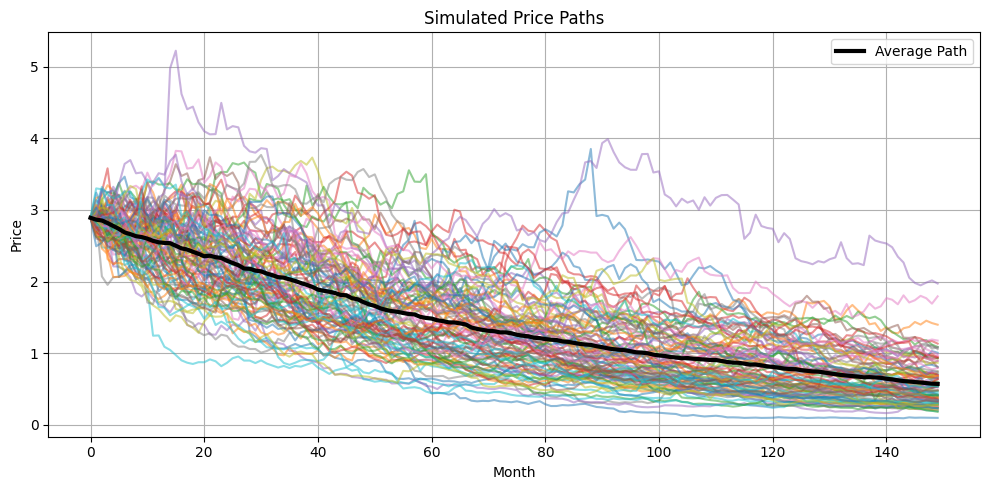

In [54]:
import numpy as np
import matplotlib.pyplot as plt

selected_key = next(iter(detailed_prices))
price_paths = detailed_prices[selected_key]

# Flatten all prices across all runs and time steps.
all_prices = np.concatenate(price_paths)
P0 = price_paths[0][0]  # Assume all paths start from the same initial price

# Compute descriptive statistics.
stats = {
    "Mean": np.mean(all_prices),
    "Median": np.median(all_prices),
    "Min": np.min(all_prices),
    "Max": np.max(all_prices),
    "Std Dev": np.std(all_prices),
    "5th %ile": np.percentile(all_prices, 5),
    "95th %ile": np.percentile(all_prices, 95)
}

# Print stats with % change from initial price.
print("--- Simulated Price Stats (Price Change from now) ---")
for label, value in stats.items():
    pct_change = ((value - P0) / P0) * 100
    print(f"{label:12}: {value:.4f} ({pct_change:+.2f}%)")

# Plot price paths
plt.figure(figsize=(10, 5))
for run in range(len(price_paths)):
    plt.plot(price_paths[run], alpha=0.5)

# Overlay average path
avg_path = np.mean(price_paths, axis=0)
plt.plot(avg_path, label='Average Path', linewidth=3, color='black')
plt.xlabel("Month")
plt.ylabel("Price")
plt.title("Simulated Price Paths")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


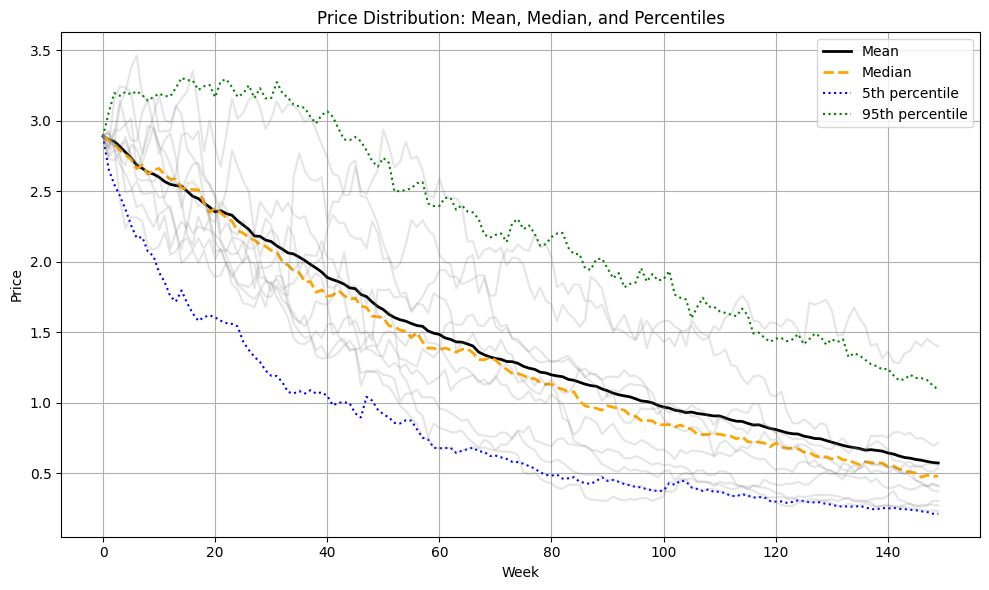

In [ ]:
price_matrix = np.array(price_paths)
avg_path = np.mean(price_matrix, axis=0)
median_path = np.median(price_matrix, axis=0)
p5 = np.percentile(price_matrix, 5, axis=0)
p95 = np.percentile(price_matrix, 95, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(avg_path, label='Mean', linewidth=2, color='black')
plt.plot(median_path, label='Median', linewidth=2, linestyle='--', color='orange')
plt.plot(p5, label='5th percentile', linestyle=':', color='blue')
plt.plot(p95, label='95th percentile', linestyle=':', color='green')

for i in range(10):
    plt.plot(price_matrix[i], alpha=0.2, color='gray')

plt.title("Price Distribution: Mean, Median, and Percentiles")
plt.xlabel("Week")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Analysis of the simulation

Some metrics first.

In [56]:
from tabulate import tabulate

# Prepare table data
summary_rows = []
for key in detailed_ann_irr:
    discount, hedge_ratio, funding_rate = key
    irr_list = [x for x in detailed_ann_irr[key] if x is not None]
    pnl_list = [x for x in detailed_pnl[key] if x is not None]

    if not irr_list or not pnl_list:
        continue

    expected_irr = np.mean(irr_list)
    median_irr = np.median(irr_list)
    p5_irr = np.percentile(irr_list, 5)
    p95_irr = np.percentile(irr_list, 95)

    expected_pnl = np.mean(pnl_list)
    median_pnl = np.median(pnl_list)
    p5_pnl = np.percentile(pnl_list, 5)
    p95_pnl = np.percentile(pnl_list, 95)

    summary_rows.append([
        round(discount, 3),
        round(hedge_ratio, 3),
        round(funding_rate, 3),
        f"{expected_irr:.2%}",
        f"{median_irr:.2%}",
        f"{p5_irr:.2%}",
        f"{p95_irr:.2%}",
        f"{expected_pnl:,.2f}",
        f"{median_pnl:,.2f}",
        f"{p5_pnl:,.2f}",
        f"{p95_pnl:,.2f}"
    ])

# Define headers
headers = [
    "Discount", "Hedge Ratio", "Funding Rate",
    "Mean IRR", "Median IRR", "5th %ile IRR", "95th %ile IRR",
    "Mean PnL", "Median PnL", "5th %ile PnL", "95th %ile PnL"
]

# Print table
print("\n📊 IRR & PnL Summary (Mean, Median, Percentiles):\n")
print(tabulate(summary_rows, headers=headers, tablefmt="psql"))



📊 IRR & PnL Summary (Mean, Median, Percentiles):

+------------+---------------+----------------+------------+--------------+----------------+-----------------+-------------+--------------+----------------+-----------------+
|   Discount |   Hedge Ratio |   Funding Rate | Mean IRR   | Median IRR   | 5th %ile IRR   | 95th %ile IRR   | Mean PnL    | Median PnL   | 5th %ile PnL   | 95th %ile PnL   |
|------------+---------------+----------------+------------+--------------+----------------+-----------------+-------------+--------------+----------------+-----------------|
|      0.3   |          0.44 |           -0.5 | -23.25%    | -23.92%      | -30.29%        | -14.67%         | -427,046.91 | -436,126.68  | -530,362.24    | -300,434.82     |
|      0.3   |          0.72 |           -0.5 | -16.77%    | -16.74%      | -21.11%        | -12.64%         | -400,342.39 | -395,212.05  | -552,132.37    | -270,276.75     |
|      0.3   |          1    |           -0.5 | -11.79%    | -11.33%      

Pricing the deal against a benchmark IRR

In [57]:
target_irr = 0.25  # 25%
target_hedge_ratio = 0.44
target_funding_rate = -0.5

# Filter results for fixed hedge ratio and funding rate
candidates = results_df[
    (results_df["hedge_ratio"] == round(target_hedge_ratio, 3)) &
    (results_df["funding_rate"] == round(target_funding_rate, 3))
].copy()

# Compute error vs target IRR
candidates["IRR_error"] = np.abs(candidates["median_Annualized_IRR"] - target_irr)

# Find closest discount level
best_row = candidates.loc[candidates["IRR_error"].idxmin()]

print("Best Discount for ~25% IRR:")
print(f"Discount: {best_row['discount']:.2%}")
print(f"Expected IRR: {best_row['median_Annualized_IRR']:.2%}")
print(f"Expected PnL: {best_row['median_Total_PnL']:,.2f} USDT")


Best Discount for ~25% IRR:
Discount: 78.98%
Expected IRR: 24.45%
Expected PnL: 229,094.05 USDT


Collateral and funding flows visualized

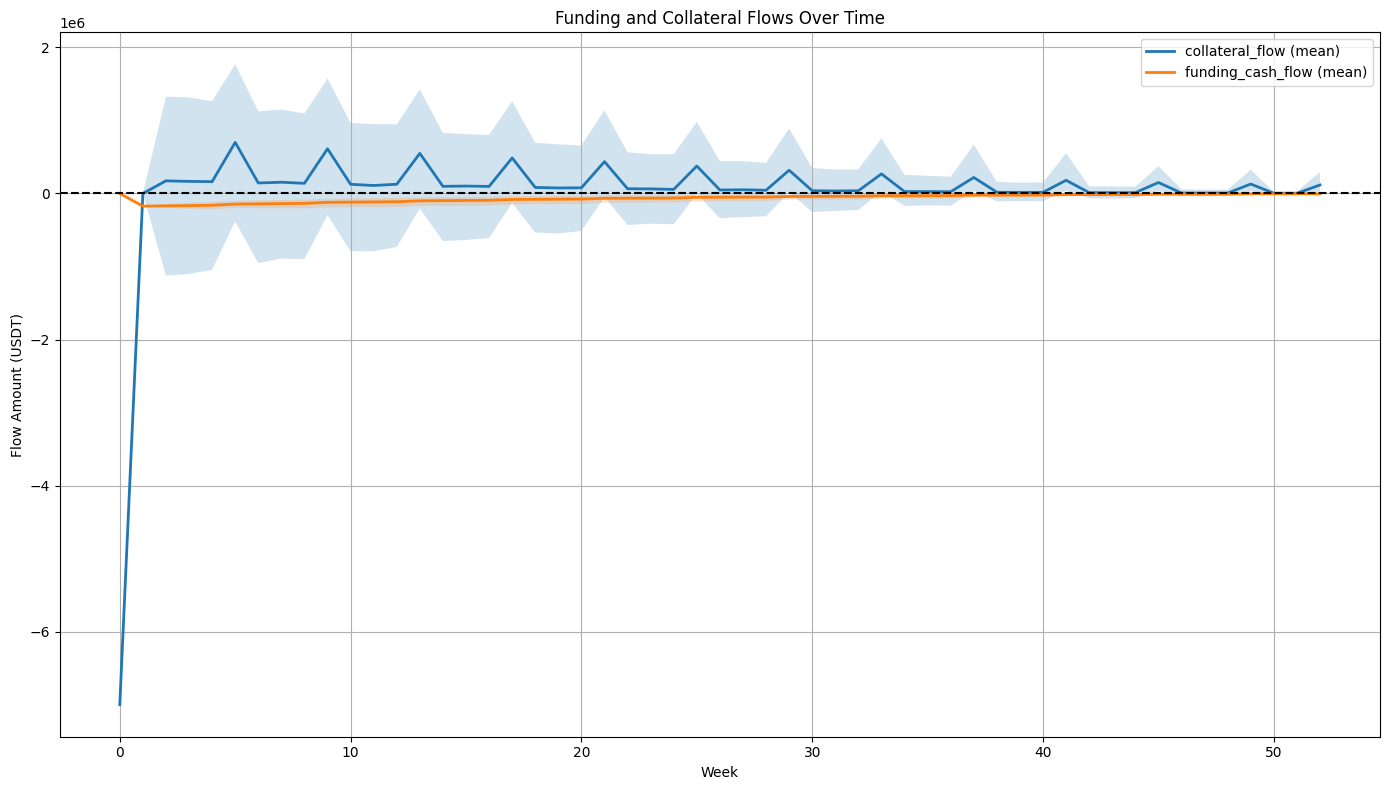

In [32]:
import matplotlib.pyplot as plt

# Choose a key that exists (you can automate or pick one)
selected_key = (0.8, 1.0, -0.6)

# Extract all DataFrames
all_dfs = detailed_simulation_details[selected_key]

# Align by week and stack
components = ["collateral_flow", "funding_cash_flow"]
summary = {comp: [] for comp in components}
weeks = None

for df in all_dfs:
    grouped = df.groupby("week")[components].sum()
    if weeks is None:
        weeks = grouped.index
    for comp in components:
        summary[comp].append(grouped[comp].values)

# Plotting
plt.figure(figsize=(14, 8))
for comp in components:
    matrix = np.array(summary[comp])
    mean_path = matrix.mean(axis=0)
    p5 = np.percentile(matrix, 5, axis=0)
    p95 = np.percentile(matrix, 95, axis=0)

    plt.plot(weeks, mean_path, label=f"{comp} (mean)", linewidth=2)
    plt.fill_between(weeks, p5, p95, alpha=0.2)

plt.axhline(0, color='black', linestyle='--')
plt.title("Funding and Collateral Flows Over Time")
plt.xlabel("Week")
plt.ylabel("Flow Amount (USDT)")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

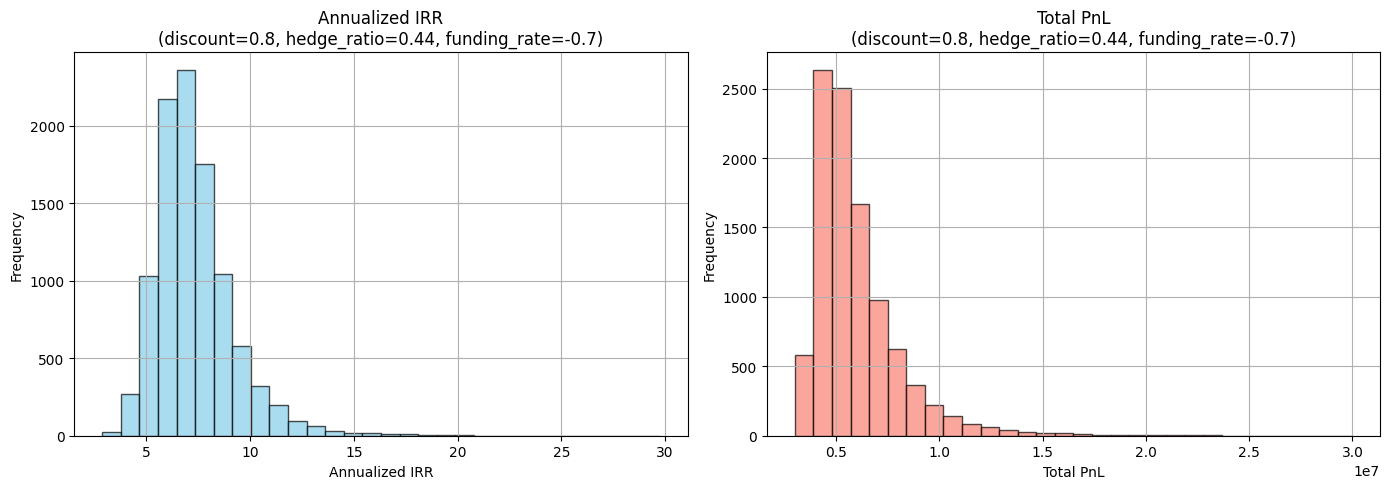

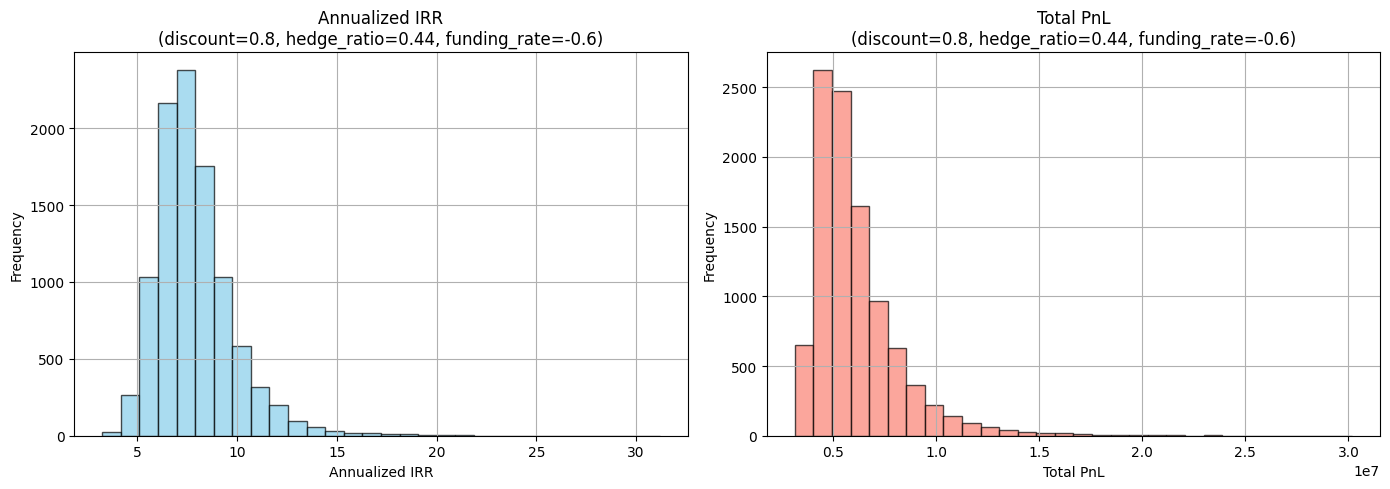

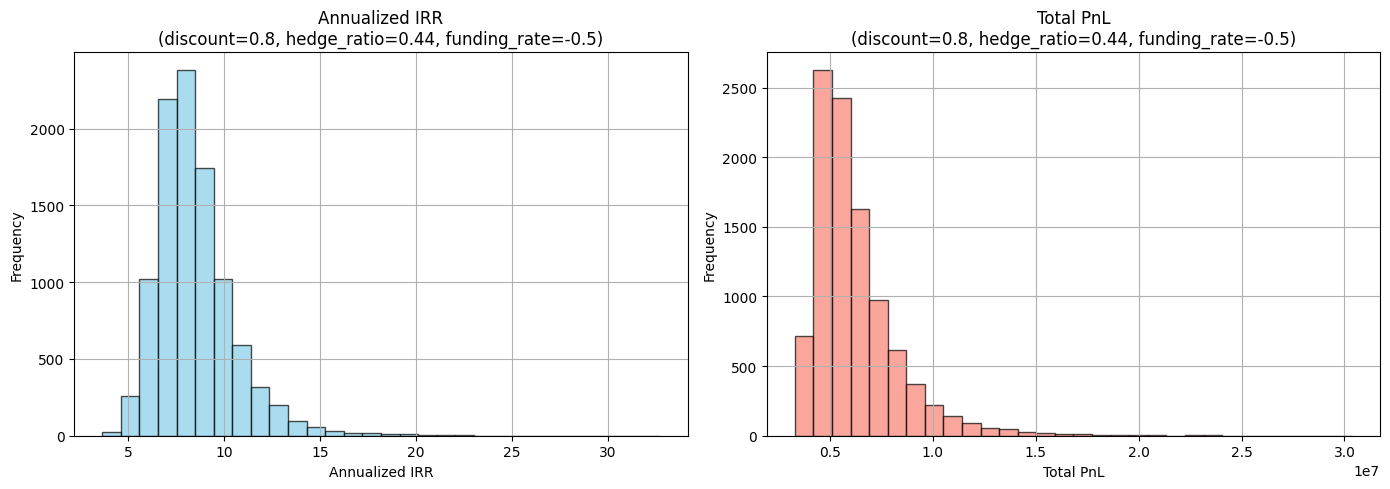

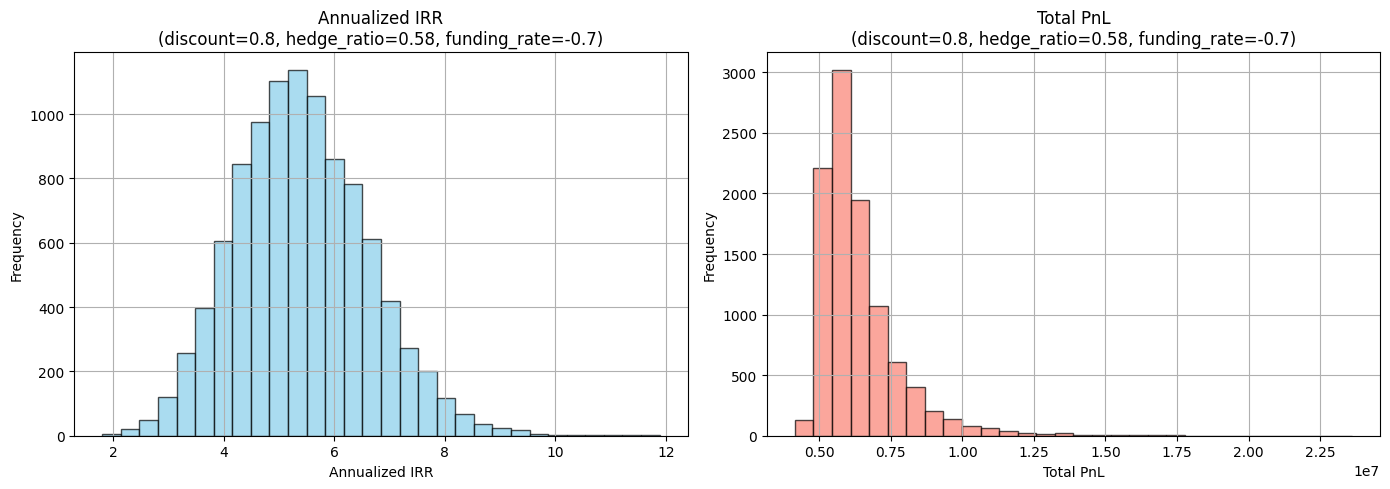

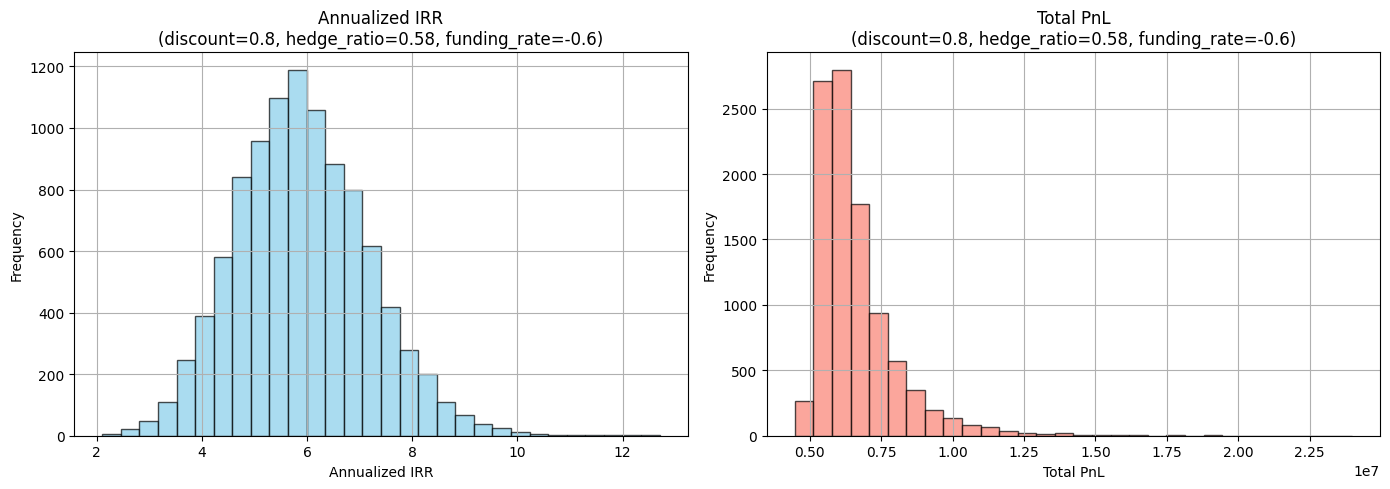

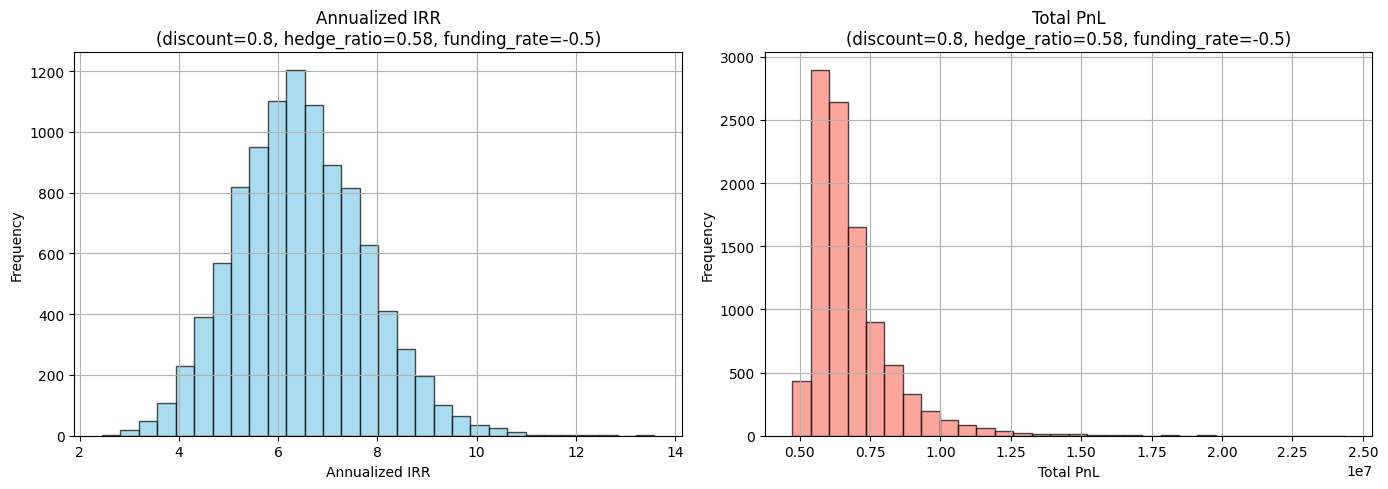

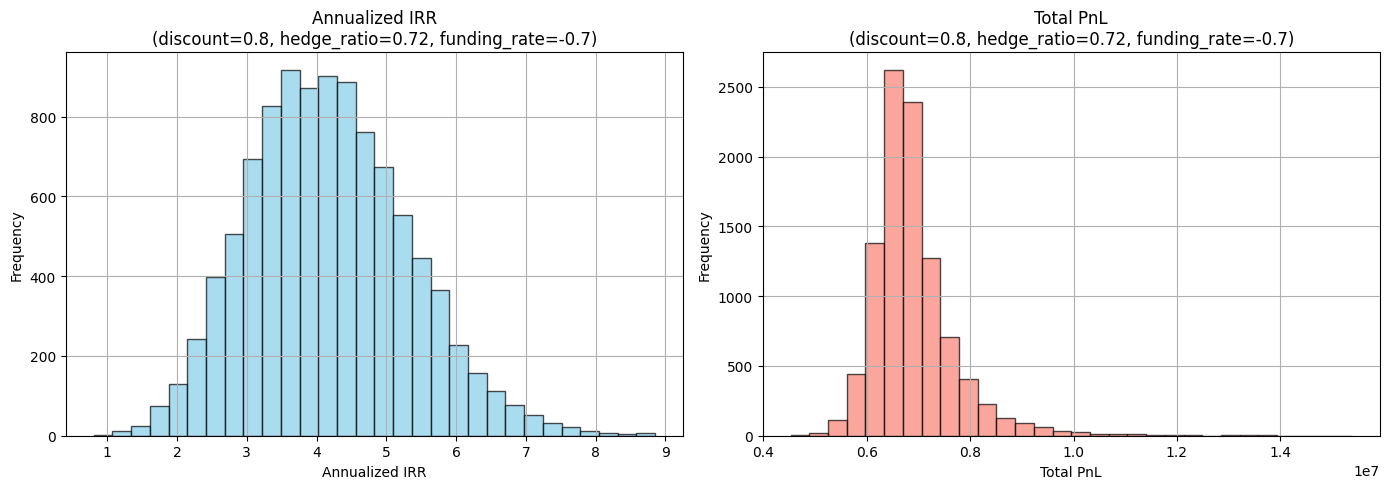

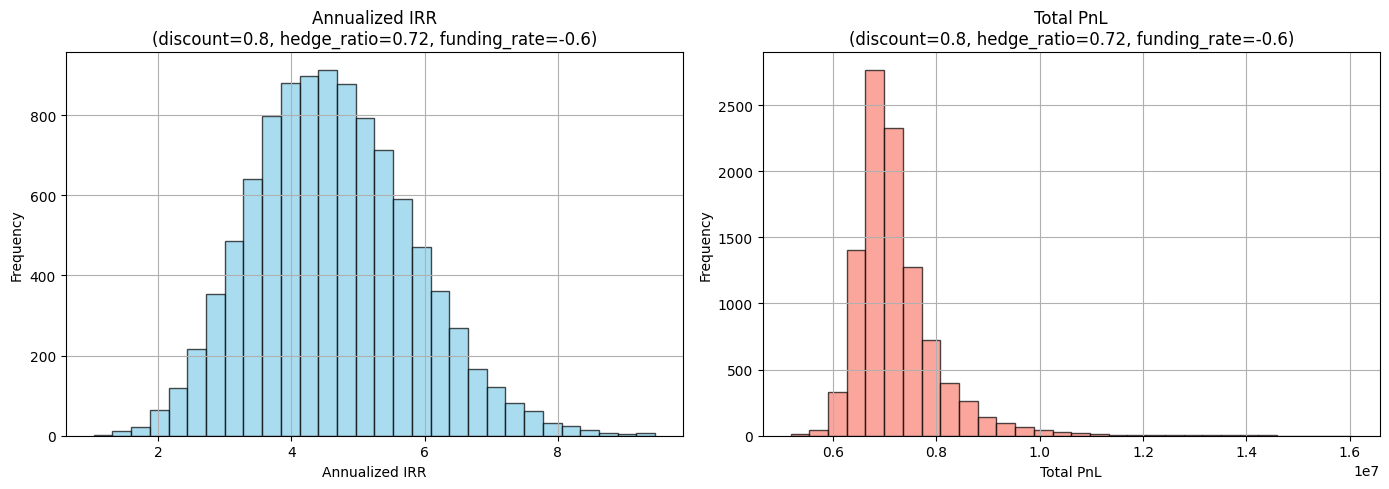

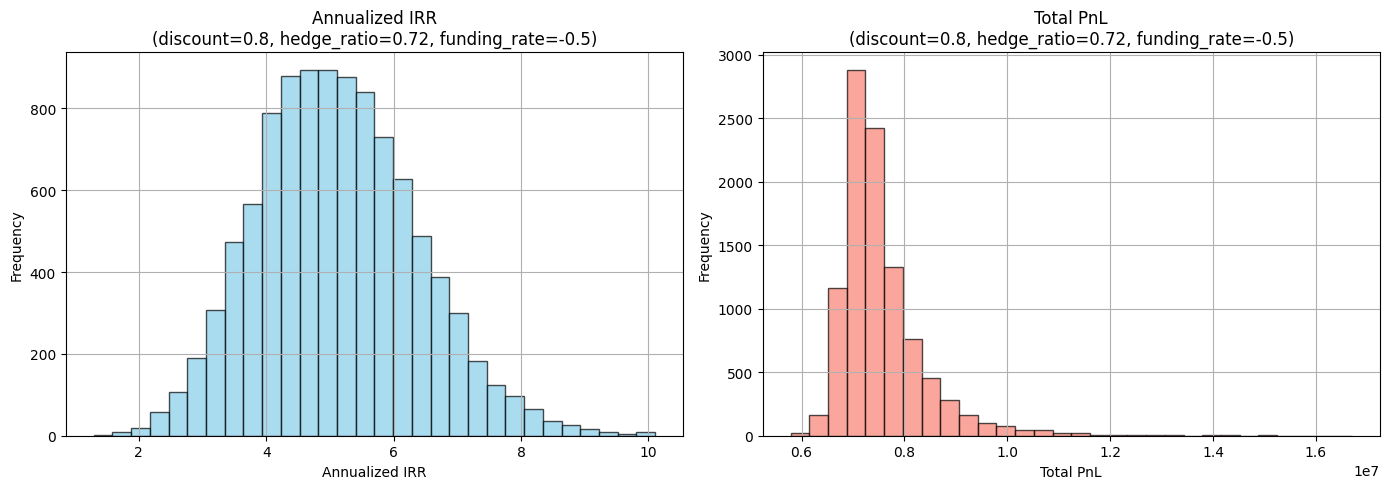

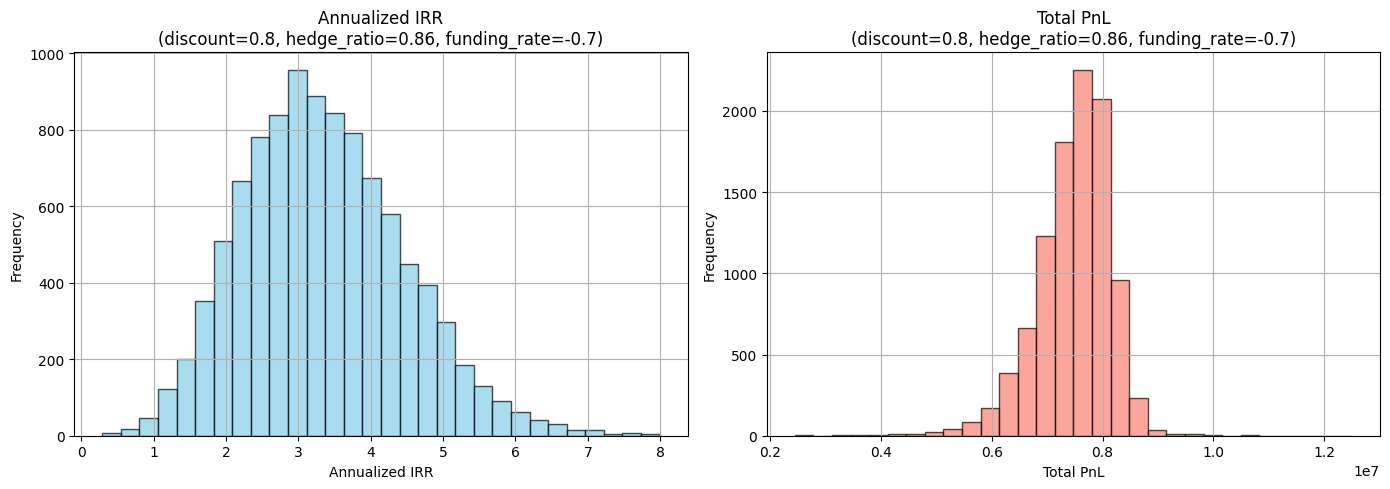

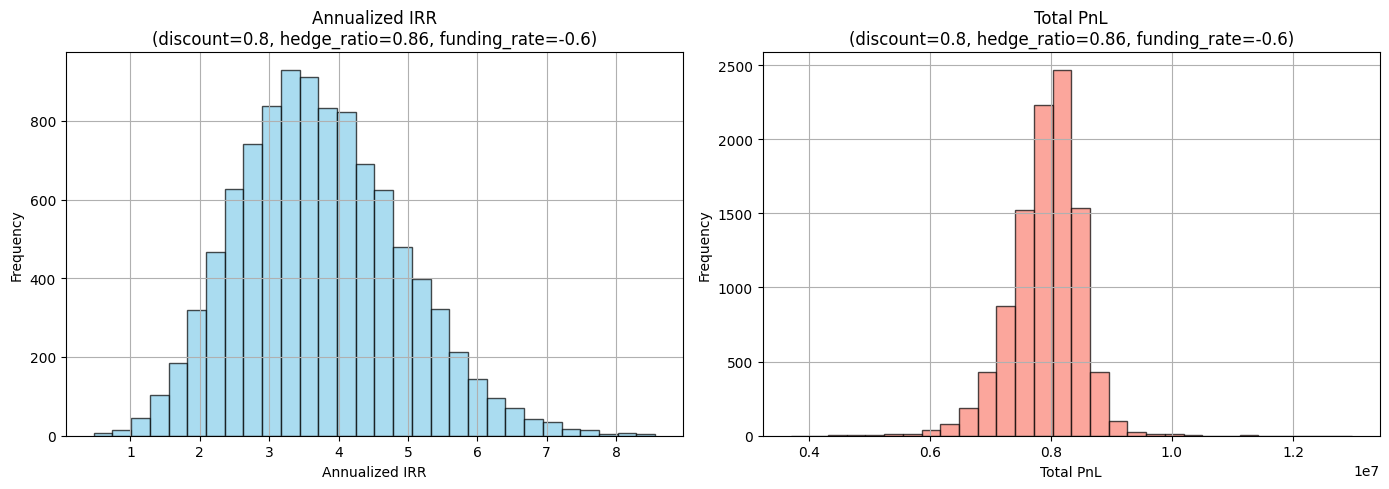

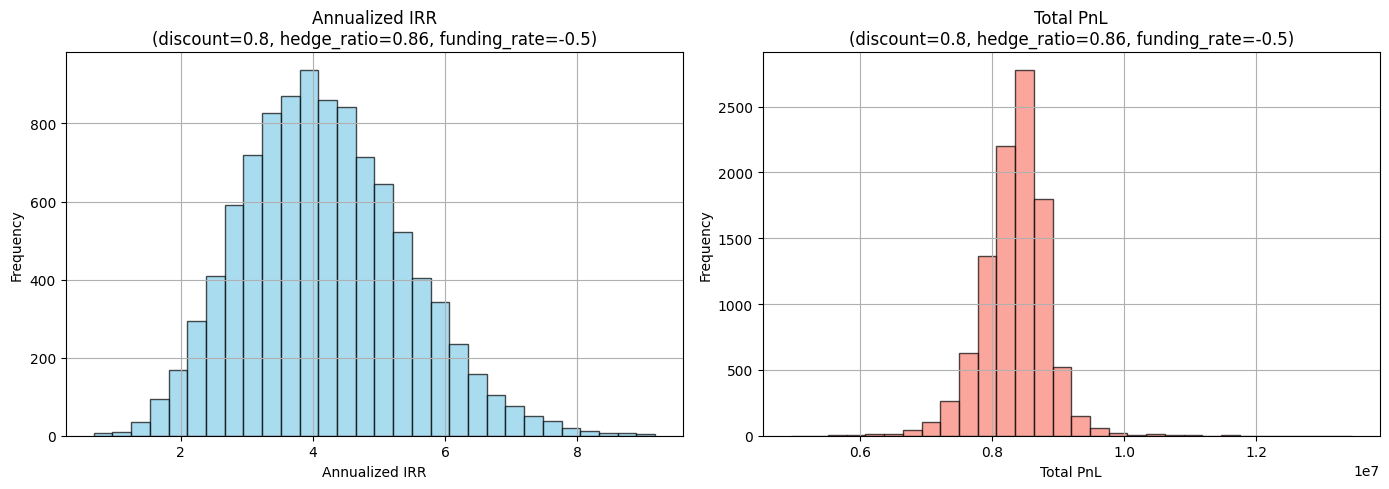

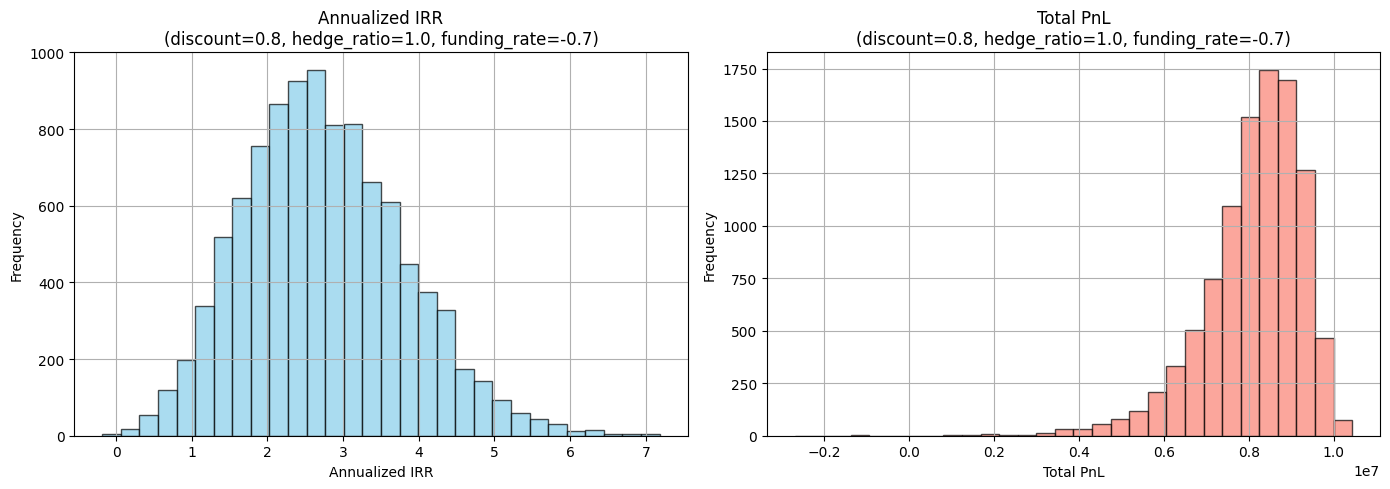

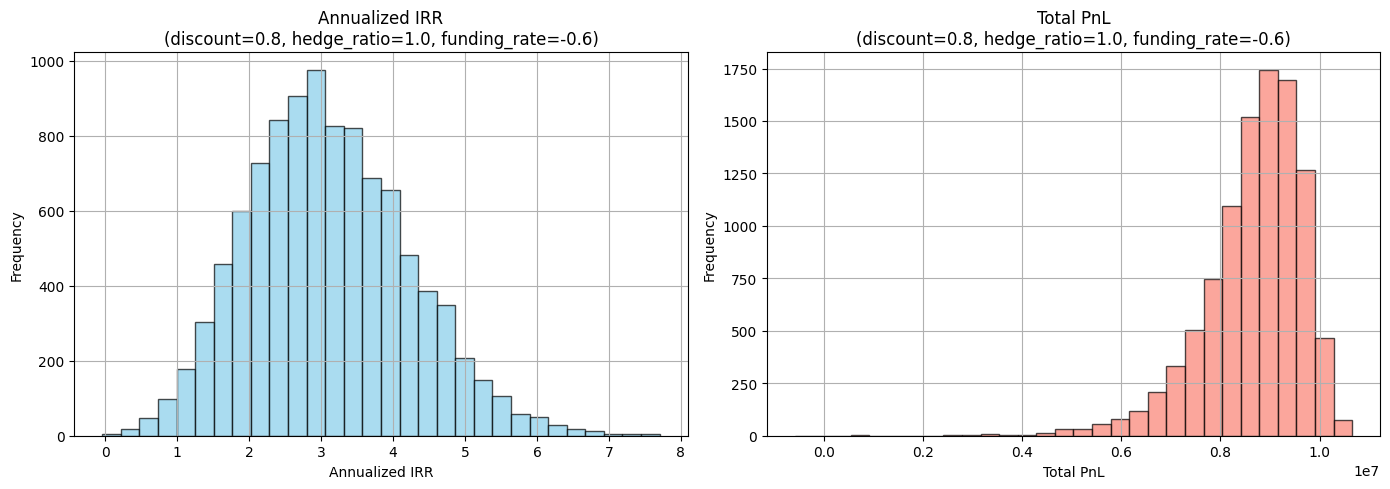

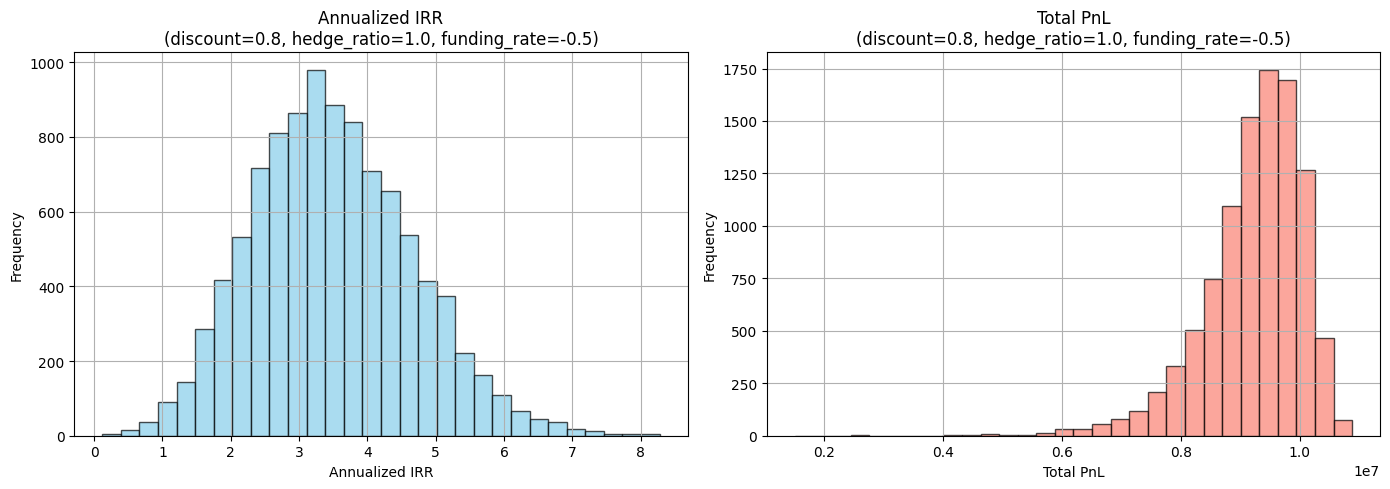

In [ ]:
# Create histograms for each combination of parameters
for key in sorted(detailed_ann_irr.keys()):
    disc, hedg, fund = key
    
    if fund in [-0.7, -0.6, -0.5]:
        ann_irr_values = detailed_ann_irr[key]
        pnl_values = detailed_pnl[key]
        
        # Create a figure with two subplots: one for Annualized IRR and one for Total PnL
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot histogram for Annualized IRR
        ax1.hist(ann_irr_values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_xlabel("Annualized IRR")
        ax1.set_ylabel("Frequency")
        ax1.set_title(f"Annualized IRR\n(discount={disc}, hedge_ratio={hedg}, funding_rate={fund})")
        ax1.grid(True)
        
        # Plot histogram for Total PnL
        ax2.hist(pnl_values, bins=30, alpha=0.7, color='salmon', edgecolor='black')
        ax2.set_xlabel("Total PnL")
        ax2.set_ylabel("Frequency")
        ax2.set_title(f"Total PnL\n(discount={disc}, hedge_ratio={hedg}, funding_rate={fund})")
        ax2.grid(True)
        
        # Adjust layout and show the plots
        plt.tight_layout()
        plt.show()

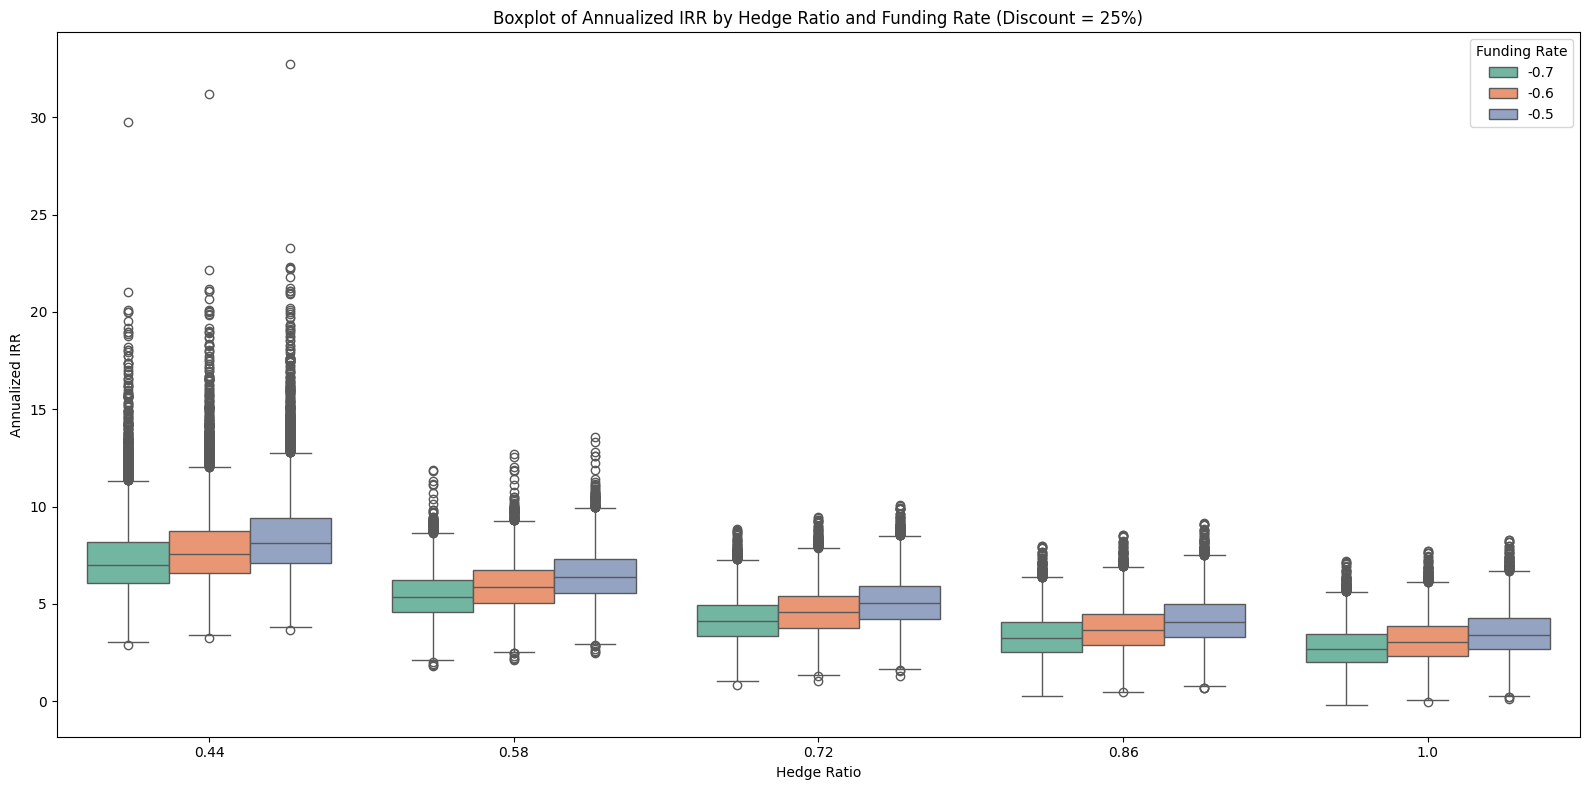

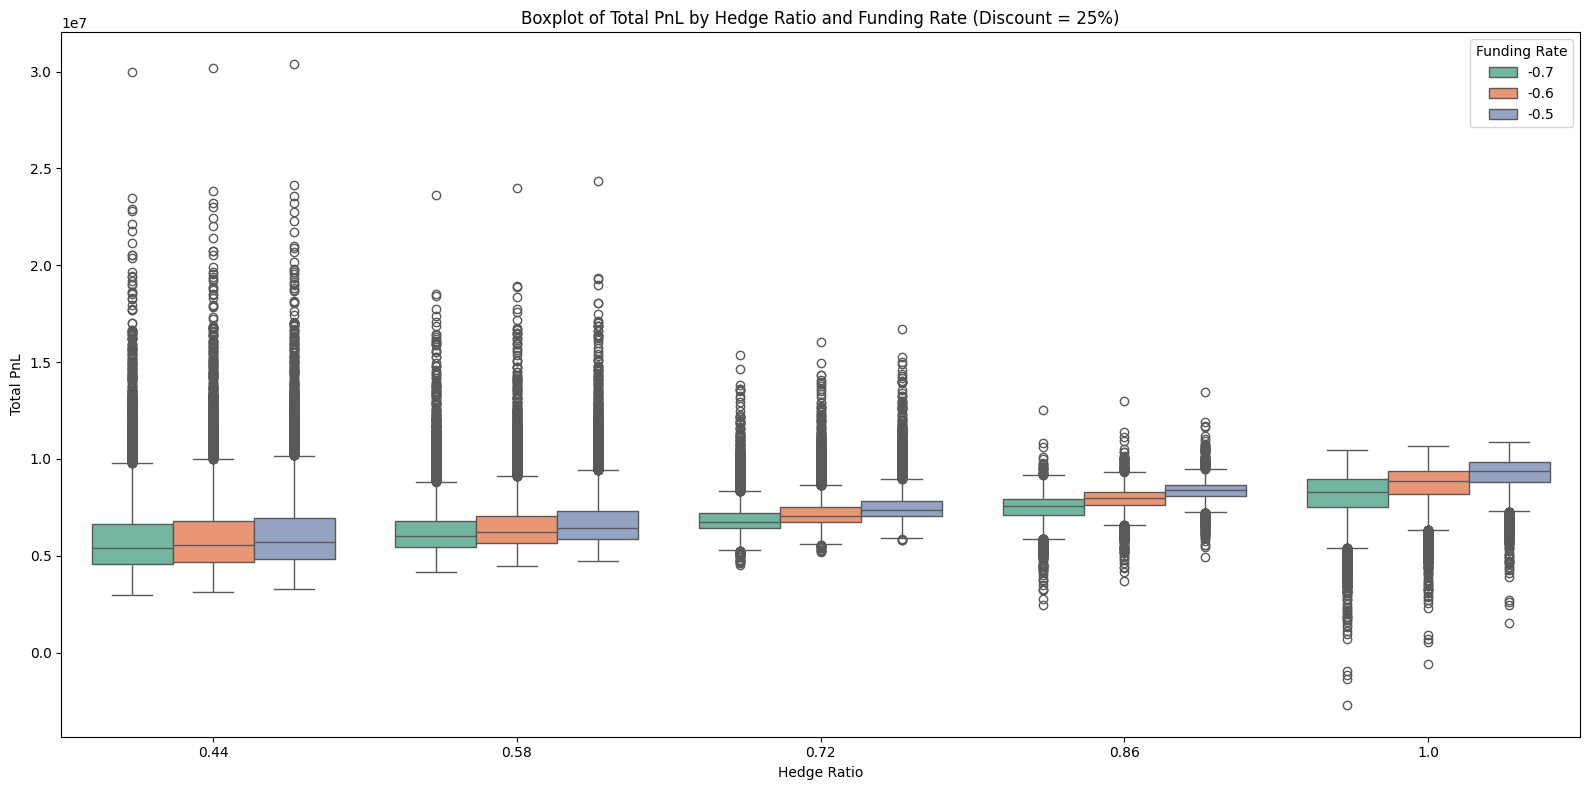

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for easier handling (flatten the dictionary)
all_results = []
for key in sorted(detailed_ann_irr.keys()):
    disc, hedg, fund = key
    ann_irr_values = detailed_ann_irr[key]
    pnl_values = detailed_pnl[key]
    
    # Add results to the DataFrame
    for ann_irr, pnl in zip(ann_irr_values, pnl_values):
        all_results.append({
            "discount": disc,
            "hedge_ratio": hedg,
            "funding_rate": fund,
            "Annualized_IRR": ann_irr,
            "Total_PnL": pnl
        })

# Convert to DataFrame
results_df_box = pd.DataFrame(all_results)

# Filter the DataFrame for 30% discount
results_df_box_filtered = results_df_box[results_df_box['discount'] == 0.8]

# Filter only for funding rates 0.0 and 0.1
results_df_box_filtered = results_df_box_filtered[results_df_box_filtered['funding_rate'].isin([-0.7, -0.6, -0.5])]

# Set the figure size
plt.figure(figsize=(16, 8))

# Create a boxplot for Annualized IRR
sns.boxplot(x="hedge_ratio", y="Annualized_IRR", hue="funding_rate", data=results_df_box_filtered, 
            palette="Set2", showfliers=True)
plt.title("Boxplot of Annualized IRR by Hedge Ratio and Funding Rate (Discount = 25%)")
plt.xlabel("Hedge Ratio")
plt.ylabel("Annualized IRR")
plt.legend(title="Funding Rate")
plt.tight_layout()
plt.show()

# Create a boxplot for Total PnL
plt.figure(figsize=(16, 8))
sns.boxplot(x="hedge_ratio", y="Total_PnL", hue="funding_rate", data=results_df_box_filtered, 
            palette="Set2", showfliers=True)
plt.title("Boxplot of Total PnL by Hedge Ratio and Funding Rate (Discount = 25%)")
plt.xlabel("Hedge Ratio")
plt.ylabel("Total PnL")
plt.legend(title="Funding Rate")
plt.tight_layout()
plt.show()


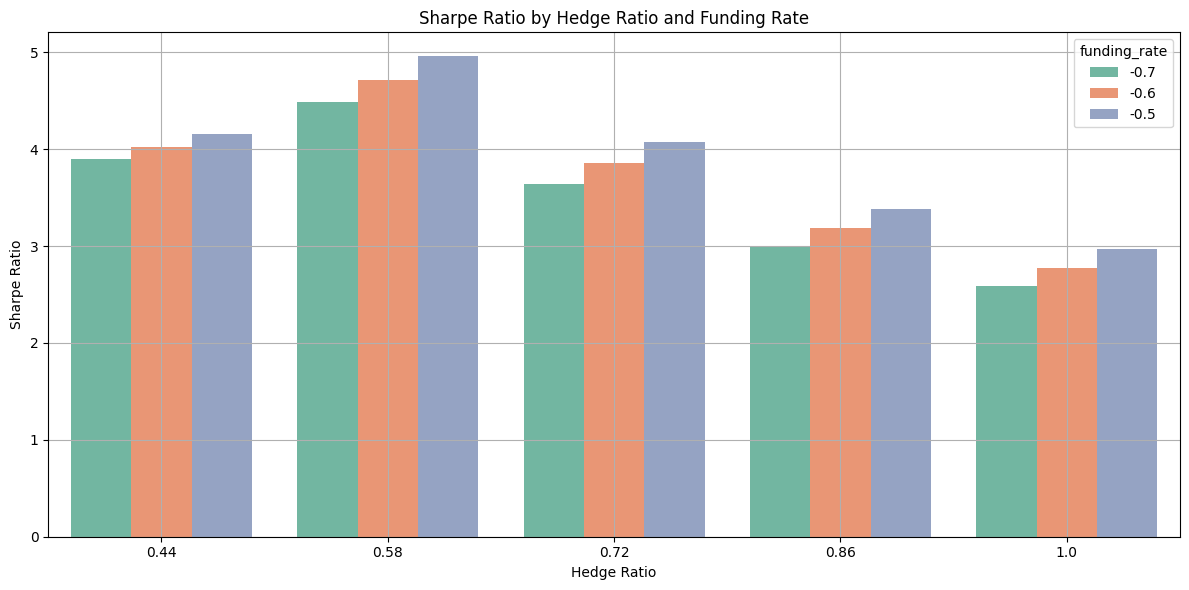

In [20]:
# Set your assumed risk-free rate
risk_free_rate = 0.0

# Group and calculate mean, std, and Sharpe ratio
sharpe_summary = results_df_box_filtered.groupby(["hedge_ratio", "funding_rate"]).agg(
    mean_irr=("Annualized_IRR", "mean"),
    std_irr=("Annualized_IRR", "std")
).reset_index()

# Calculate Sharpe Ratio
sharpe_summary["sharpe_ratio"] = (sharpe_summary["mean_irr"] - risk_free_rate) / sharpe_summary["std_irr"]
plt.figure(figsize=(12, 6))
sns.barplot(data=sharpe_summary, x="hedge_ratio", y="sharpe_ratio", hue="funding_rate", palette="Set2")
plt.title("Sharpe Ratio by Hedge Ratio and Funding Rate")
plt.xlabel("Hedge Ratio")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()



In [21]:
import pandas as pd
from tabulate import tabulate

# Function to get the best hedge_ratio based on a given metric (e.g., avg IRR, median IRR, etc.)
def get_best_hedge_ratio(df, metric='median_total_PnL'):
    best_hedge_ratio = {}

    # Group by discount and funding rate to find the best hedge ratio for each combination
    for (discount, funding_rate) in df[['discount', 'funding_rate']].drop_duplicates().values:
        # Filter results for the given discount and funding rate
        discount_funding_group = df[(df['discount'] == discount) & (df['funding_rate'] == funding_rate)]
        
        # Get the best hedge ratio by selecting the row with the highest value for the given metric
        best_row = discount_funding_group.loc[discount_funding_group[metric].idxmax()]
        
        # Store the best hedge ratio
        best_hedge_ratio[(discount, funding_rate)] = best_row['hedge_ratio']
    
    return best_hedge_ratio

# Find the best hedge ratio based on the average IRR for each discount and funding rate
best_hedge_ratio_avg_irr = get_best_hedge_ratio(results_df, metric='median_Annualized_IRR')

# Convert the results into a DataFrame for easy display
best_hedge_ratio_df = pd.DataFrame.from_dict(best_hedge_ratio_avg_irr, orient='index', columns=['best_hedge_ratio'])

# Reset the index to separate discount and funding rate
best_hedge_ratio_df.reset_index(inplace=True)


# Use tabulate to print the results in a nice table format
print("Best Hedge Ratio Based on Median IRR for Each (Funding Rate, Discount) Combination:")
print(tabulate(best_hedge_ratio_df, headers='keys', tablefmt='psql', floatfmt=".2f"))

Best Hedge Ratio Based on Median IRR for Each (Funding Rate, Discount) Combination:
+----+-------------------------------------+--------------------+
|    | index                               |   best_hedge_ratio |
|----+-------------------------------------+--------------------|
|  0 | (np.float64(0.8), np.float64(-0.7)) |               0.44 |
|  1 | (np.float64(0.8), np.float64(-0.6)) |               0.44 |
|  2 | (np.float64(0.8), np.float64(-0.5)) |               0.44 |
+----+-------------------------------------+--------------------+


In [22]:
grouped_collateral = {}

# Group by hedge_ratio only
for key, collateral_paths in detailed_collateral.items():
    hedge_ratio = key[1]  # only using hedge ratio
    if hedge_ratio not in grouped_collateral:
        grouped_collateral[hedge_ratio] = []

    for path in collateral_paths:
        grouped_collateral[hedge_ratio].extend(path)

# Compute statistics per hedge ratio
stats_dict = {}
for hedge_ratio, coll_list in grouped_collateral.items():
    all_coll = np.array(coll_list)
    stats_dict[hedge_ratio] = {
        "Mean": np.mean(all_coll),
        "Median": np.median(all_coll),
        "Min": np.min(all_coll),
        "Max": np.max(all_coll),
        "Std": np.std(all_coll),
        "5th %ile": np.percentile(all_coll, 5),
        "95th %ile": np.percentile(all_coll, 95)
    }

# Convert to DataFrame
stats_df = pd.DataFrame(stats_dict).T
stats_df.index.name = "Hedge Ratio"

# Pretty print
print("Descriptive Statistics for Collateral (Grouped by Hedge Ratio):")
print(tabulate(stats_df, headers="keys", tablefmt="psql", floatfmt=".2f"))

Descriptive Statistics for Collateral (Grouped by Hedge Ratio):
+---------------+------------+------------+---------+-------------+------------+------------+-------------+
|   Hedge Ratio |       Mean |     Median |     Min |         Max |        Std |   5th %ile |   95th %ile |
|---------------+------------+------------+---------+-------------+------------+------------+-------------|
|          0.44 |  555410.71 |       0.00 |    0.00 |  6888337.94 |  884516.04 |       0.00 |  2731782.01 |
|          0.58 |  922572.29 |  262541.34 |    0.00 | 10494185.20 | 1267267.77 |       0.00 |  3847921.77 |
|          0.72 | 1360303.28 |  601681.99 |    0.00 | 14106149.38 | 1648614.73 |       0.00 |  4899525.00 |
|          0.86 | 1857572.91 |  956341.75 |    0.00 | 17718113.56 | 2017344.07 |       0.00 |  5949525.00 |
|          1.00 | 2405241.31 | 1481808.14 | 5570.78 | 21330077.74 | 2366588.71 |   90731.36 |  6999525.00 |
+---------------+------------+------------+---------+-------------+-----

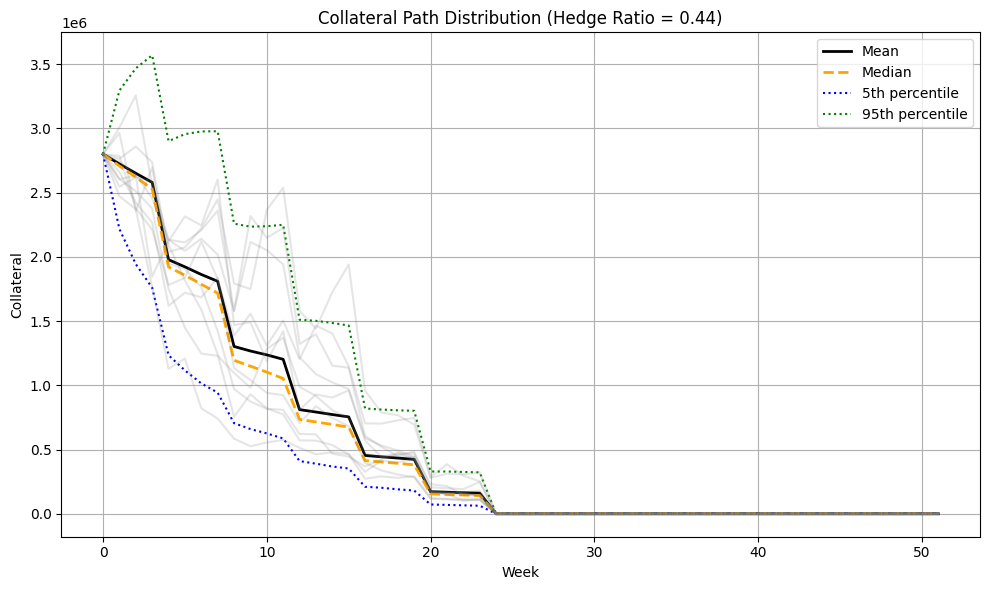

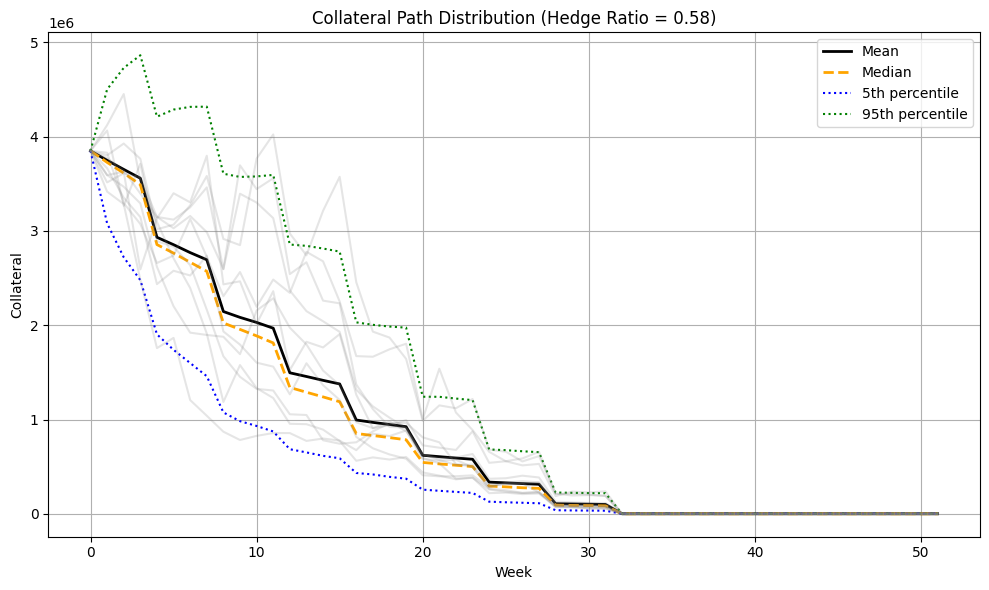

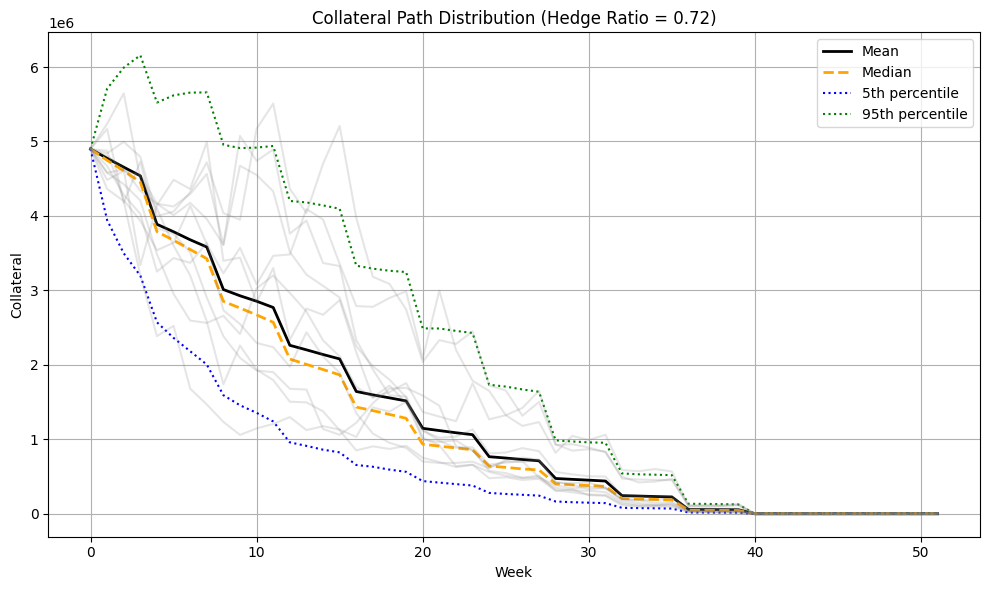

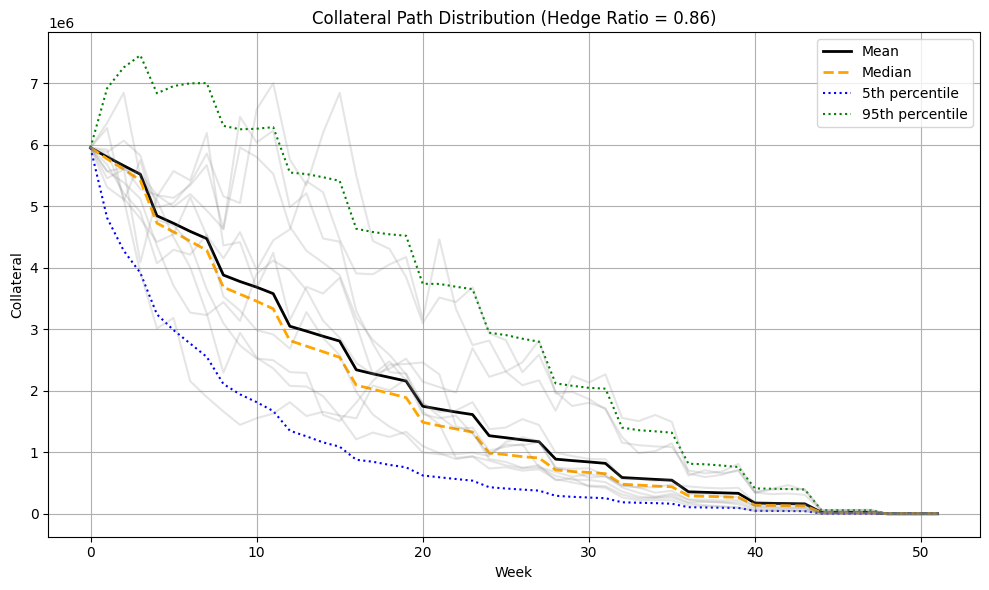

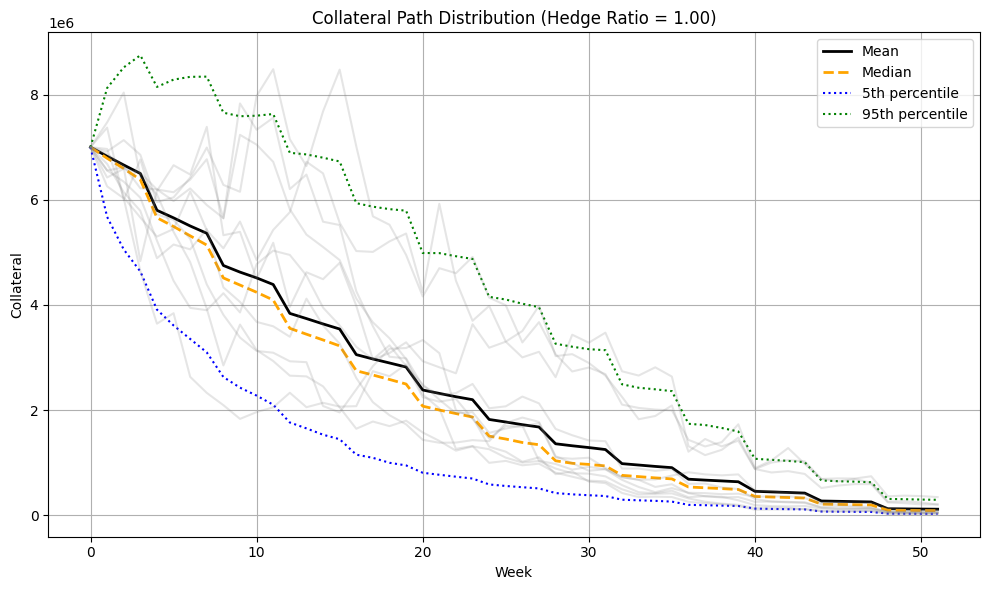

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# For each hedge ratio, build the matrix and plot
for hedge_ratio, collateral_paths in grouped_collateral.items():
    # Convert to matrix: each row = one simulation path over time
    matrix = np.array(detailed_collateral[(next(
        key for key in detailed_collateral if key[1] == hedge_ratio))])  # one key with this hedge_ratio

    avg_path = np.mean(matrix, axis=0)
    median_path = np.median(matrix, axis=0)
    p5 = np.percentile(matrix, 5, axis=0)
    p95 = np.percentile(matrix, 95, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(avg_path, label='Mean', linewidth=2, color='black')
    plt.plot(median_path, label='Median', linewidth=2, linestyle='--', color='orange')
    plt.plot(p5, label='5th percentile', linestyle=':', color='blue')
    plt.plot(p95, label='95th percentile', linestyle=':', color='green')

    # Optional: sample some paths
    for i in range(min(10, matrix.shape[0])):
        plt.plot(matrix[i], alpha=0.2, color='gray')

    plt.title(f"Collateral Path Distribution (Hedge Ratio = {hedge_ratio:.2f})")
    plt.xlabel("Week")
    plt.ylabel("Collateral")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
